<a href="https://colab.research.google.com/github/fazalpge/Tensor-flow/blob/main/parse2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Input Details: [{'name': 'inputs_0', 'index': 0, 'shape': array([  1, 640, 640,   3], dtype=int32), 'shape_signature': array([  1, 640, 640,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output Details: [{'name': 'Identity', 'index': 499, 'shape': array([   1, 8400,   85], dtype=int32), 'shape_signature': array([   1, 8400,   85], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Labels: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',

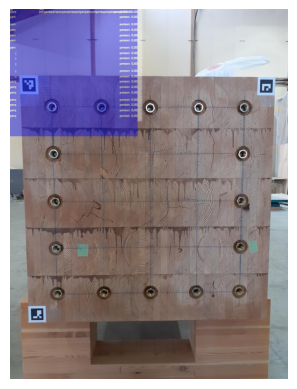

In [5]:
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="/content/yolox_s.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Details:", input_details)
print("Output Details:", output_details)

# Function to load COCO labels
def load_labels(path):
    with open(path, 'r') as f:
        return [line.strip() for line in f.readlines()]

labels = load_labels('/content/coco-labels-2014_2017.txt')
print('Labels:', labels)

# Function to preprocess the image
def preprocess_image(image_path, input_size):
    image = Image.open(image_path)
    image = image.resize(input_size)
    input_data = np.array(image, dtype=np.float32)
    input_data = np.expand_dims(input_data, axis=0)
    input_data /= 255.0  # Normalize to [0, 1]
    return input_data

# Load and preprocess the image
input_size = (input_details[0]['shape'][2], input_details[0]['shape'][1])
input_data = preprocess_image('/content/test.jfif', input_size)
print('Preprocessed image shape:', input_data.shape)

# Set the tensor to point to the input data to be inferred
interpreter.set_tensor(input_details[0]['index'], input_data)
print('Input tensor set with data shape:', input_data.shape)

# Run inference
interpreter.invoke()
print("Model inference executed")

# Get the output tensors
output_data = interpreter.get_tensor(output_details[0]['index'])
print('Output data retrieved:', output_data)

# Assuming output_data is similar to the PyTorch 'outputs' tensor structure
bbox_preds = output_data[:, :, :4]  # [batch, n_anchors_all, 4]
obj_preds = output_data[:, :, 4:5]  # [batch, n_anchors_all, 1]
cls_preds = output_data[:, :, 5:]  # [batch, n_anchors_all, n_cls]

# Assuming labels and other necessary inputs are defined similarly

# Example code to convert PyTorch processing to TensorFlow Lite:
boxes = bbox_preds[0]  # Assuming batch size 1 for simplicity
scores = np.max(obj_preds[0], axis=1)  # Assuming binary object prediction
classes = np.argmax(cls_preds[0], axis=1)


# Function to draw bounding boxes
def draw_boxes(image, boxes, classes, scores, labels):
    overlay = image.copy()
    alpha = 0.4  # Adjust the transparency here

    for box, cls, score in zip(boxes, classes, scores):
        ymin, xmin, ymax, xmax = box
        label = f'{labels[int(cls)]}: {score:.2f}' if cls is not None and score is not None else 'Unknown'

        cv2.rectangle(overlay, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), cv2.FILLED)
        cv2.putText(overlay, label, (int(xmin), int(ymin) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)
    return image

# Draw bounding boxes on the image if outputs are valid
if boxes is not None and classes is not None and scores is not None:
    image = cv2.imread('/content/test.jfif')
    image = draw_boxes(image, boxes, classes, scores, labels)
    print('Bounding boxes drawn on the image')

# Display the image
try:
    # Convert image to RGB for matplotlib
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print("Image converted to RGB")

    plt.imshow(rgb_image)
    plt.axis('off')
    plt.show()

except Exception as e:
    print("No output data returned from the model.", e)
